<a href="https://colab.research.google.com/github/avladova/Railway-track-deviations/blob/main/ParameterGrid_Railway_deviations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm

from pandas_profiling import ProfileReport

import re
import datetime as dt
import seaborn as sns
import plotly.express as px
import missingno as msno
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import shapiro
from scipy import stats
import statsmodels.api as sm

import logging
import warnings
import sys
from prophet import Prophet
import cmdstanpy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

%matplotlib inline

In [4]:
#https://docs.google.com/spreadsheets/d/1MnS2dLOKbDqhNt69x7jP1Mxw9x-_j2pK/edit#gid=562329222

sheet_url="https://docs.google.com/spreadsheets/d/1MnS2dLOKbDqhNt69x7jP1Mxw9x-_j2pK/edit#gid=562329222"
url = sheet_url.replace('/edit#gid=', '/export?format=xlsx&gid=')
raw=pd.read_excel(url, 
                  dtype={'ВРЕМЯ': datetime, 'ГОД':int, 'МЕСЯЦ':int,'КМ':int, 'М':int, 'ДИСТАНЦИЯ':int, 
                         'КОДОТСТУП':int, 'НОРМА':int, 'СТЕПЕНЬ':int})
raw.rename(columns={'КМ':'Km','М':'M','АМПЛИТУДА':'Amplitude', 'HOPMA':'Normative', 'КОДОТСТУП':'Code' ,'ГОД':'Year','МЕСЯЦ':'Month', 
                    'ДЕНЬ':'Day' , 'СТЕПЕНЬ':'Danger', 'ДЛИНА':'Length', 'ОТСТУПЛЕНИЕ':'Type', 'ВРЕМЯ':'Time'}, inplace=True)  
#
print(raw.info())
raw.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Km         1657 non-null   int64         
 1   M          1657 non-null   int64         
 2   Amplitude  1657 non-null   int64         
 3   Normative  1657 non-null   int64         
 4   Code       1657 non-null   int64         
 5   Year       1657 non-null   int64         
 6   Month      1657 non-null   int64         
 7   Day        1657 non-null   int64         
 8   Danger     1657 non-null   int64         
 9   Length     1657 non-null   int64         
 10  Type       1657 non-null   object        
 11  Time       1657 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 155.5+ KB
None


,Km,M,Amplitude,Normative,Code,Year,Month,Day,Danger,Length,Type,Time
1459,613,882,11,0,2065,2021,2,22,1,9,Р,2021-02-22
874,632,612,17,0,2065,2019,4,25,2,26,Р,2019-04-25
266,631,517,17,0,2065,2018,7,21,2,37,Р,2018-07-21
195,610,308,20,0,2065,2018,6,19,2,20,Р,2018-06-19
865,622,94,16,0,2065,2019,4,23,2,29,Р,2019-04-23


In [5]:
url='https://github.com/avladova/Railway-track-deviations/blob/main/fragment.xlsx?raw=true'
#raw = pd.read_excel(url, index_col=None) 
#raw.rename(columns={'КМ':'Km','М':'M','АМПЛИТУДА':'Amplitude', 'HOPMA':'Normative', 'КОДОТСТУП':'Code' ,'ГОД':'Year','МЕСЯЦ':'Month', 
#                    'ДЕНЬ':'Day' , 'СТЕПЕНЬ':'Danger', 'ДЛИНА':'Length', 'ОТСТУПЛЕНИЕ':'Type', 'ВРЕМЯ':'Time'}, inplace=True)  
#print(raw.info())

In [6]:
df=raw.copy()
resRep = []
for colName in df.columns:
    col = df[colName]
    resRep.append([colName,col.dtype,len(col.unique()),sum(~col.isna()),col.unique()[:8]])
pd.DataFrame(resRep,columns=['feature','Type','Uniq','not NaN','Example'])

,feature,Type,Uniq,not NaN,Example
0,Km,int64,40,1657,"[19, 634, 26, 610, 611, 630, 631, 638]"
1,M,int64,685,1657,"[146, 801, 839, 595, 838, 786, 784, 788]"
2,Amplitude,int64,36,1657,"[18, 13, 17, 19, 22, 20, 11, 12]"
3,Normative,int64,1,1657,[0]
4,Code,int64,1,1657,[2065]
5,Year,int64,4,1657,"[2018, 2020, 2019, 2021]"
6,Month,int64,12,1657,"[5, 7, 8, 9, 6, 10, 11, 12]"
7,Day,int64,28,1657,"[18, 24, 13, 1, 12, 26, 19, 15]"
8,Danger,int64,4,1657,"[2, 1, 3, 4]"
9,Length,int64,36,1657,"[33, 14, 26, 23, 22, 16, 13, 15]"


# Feature Engineering

In [7]:
df['Danger'].replace(3, 34, inplace=True)
df['Danger'].replace(4, 34, inplace=True)
df['Danger'].nunique()

3

In [8]:
df['Time'] = df.apply(lambda r: datetime.strptime(f"{r['Year']} {r['Month']} {r['Day']}", '%Y %m %d'), axis=1)
df['Track'] = df['Km']*1000+df['M']
df['Deviation']=df['Amplitude']-df['Normative']
df['Square_A']=df['Amplitude']*df['Length']
df['Square_D']=df['Deviation']*df['Length']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Km         1657 non-null   int64         
 1   M          1657 non-null   int64         
 2   Amplitude  1657 non-null   int64         
 3   Normative  1657 non-null   int64         
 4   Code       1657 non-null   int64         
 5   Year       1657 non-null   int64         
 6   Month      1657 non-null   int64         
 7   Day        1657 non-null   int64         
 8   Danger     1657 non-null   int64         
 9   Length     1657 non-null   int64         
 10  Type       1657 non-null   object        
 11  Time       1657 non-null   datetime64[ns]
 12  Track      1657 non-null   int64         
 13  Deviation  1657 non-null   int64         
 14  Square_A   1657 non-null   int64         
 15  Square_D   1657 non-null   int64         
dtypes: datetime64[ns](1), int64(14), object(1)

In [9]:
val = df.Type.value_counts()
y = val[val < 5000].index
df.Type = df.Type.replace({x:'Others' for x in y})

In [10]:
bin=2
df['Intervals'] = pd.cut(x=df['Km'], bins=bin, labels=False)
df['Bin']=pd.cut(x=df['Km'], bins=bin)
print(df[['Intervals','Bin']].value_counts())
df.groupby(['Intervals','Bin'])['Time'].apply(print)

Intervals  Bin            
1          (334.5, 650.0]     1323
0          (18.369, 334.5]     334
dtype: int64
0      2018-05-18
1      2018-05-18
2      2018-07-24
3      2018-08-13
4      2018-08-13
          ...    
1621   2021-02-15
1622   2021-02-15
1623   2021-02-15
1624   2021-02-15
1625   2021-02-15
Name: (0, (18.369, 334.5]), Length: 334, dtype: datetime64[ns]
24     2021-01-28
25     2021-01-28
26     2021-01-30
27     2021-01-29
28     2021-01-29
          ...    
1652   2021-02-21
1653   2021-02-21
1654   2021-02-21
1655   2021-02-21
1656   2021-02-21
Name: (1, (334.5, 650.0]), Length: 1323, dtype: datetime64[ns]


Intervals  Bin            
0          (18.369, 334.5]    None
           (334.5, 650.0]      NaN
1          (18.369, 334.5]     NaN
           (334.5, 650.0]     None
Name: Time, dtype: object

In [11]:
dfrm=df.copy()
bin_range = [i*2 for i in range(2,8)]
print(bin_range)
for bin in bin_range:
  dfrm['Intervals'] = pd.cut(x=df['Track'], bins=bin, labels=False)
  dfrm['Bin']=pd.cut(x=dfrm['Track'], bins=bin)
  print(dfrm[['Intervals', 'Bin']].sample(5))

[4, 6, 8, 10, 12, 14]
      Intervals                     Bin
1048          0  (18436.899, 176843.25]
1041          3   (492393.75, 650169.0]
1263          0  (18436.899, 176843.25]
445           3   (492393.75, 650169.0]
40            3   (492393.75, 650169.0]
      Intervals                   Bin
1542          5  (544985.5, 650169.0]
1578          5  (544985.5, 650169.0]
824           5  (544985.5, 650169.0]
1412          5  (544985.5, 650169.0]
1351          5  (544985.5, 650169.0]
      Intervals                     Bin
1399          7  (571281.375, 650169.0]
546           7  (571281.375, 650169.0]
1142          7  (571281.375, 650169.0]
377           0  (18436.899, 97955.625]
367           0  (18436.899, 97955.625]
      Intervals                   Bin
1370          0  (18436.899, 82178.1]
260           9  (587058.9, 650169.0]
1020          9  (587058.9, 650169.0]
1448          0  (18436.899, 82178.1]
1142          9  (587058.9, 650169.0]
      Intervals                    Bin
385

# Correlation Analysis

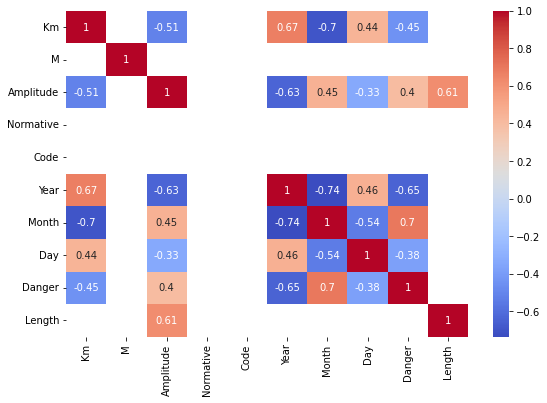

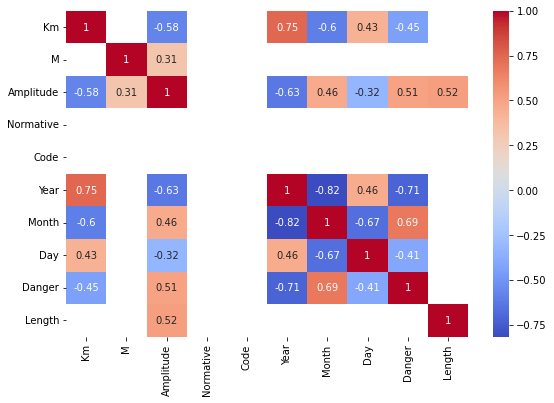

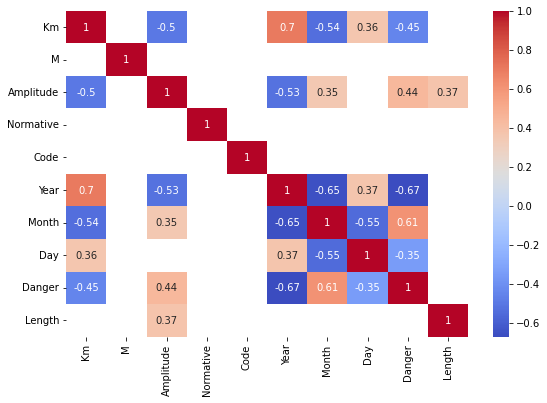

In [ ]:
colraw = raw.columns.values.tolist()
method=['pearson','spearman', 'kendall']
for m in method:
  glue=raw[colraw].corr(method=m, min_periods=3)
  mask = np.ones_like(glue, dtype=bool)
  mask[np.abs(glue) > 0.3] = False
  plt.figure(figsize=(9, 6))
  sns.heatmap(glue, annot=True, cmap='coolwarm', mask=mask)
  plt.show()

# Trend&Seasonality

In [ ]:
colraw=['Amplitude', 'Normative','Length', 'Danger']
dfrm=df.set_index('Time').copy()
scaler = MinMaxScaler(feature_range=(0, 1))
dfrm[colraw] = scaler.fit_transform(dfrm[colraw].to_numpy())

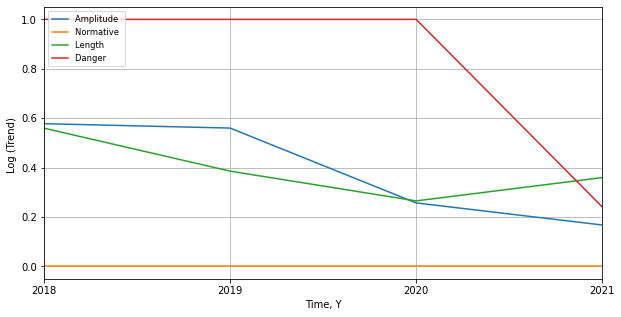

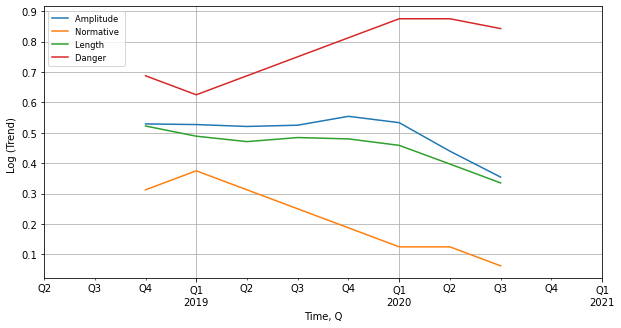

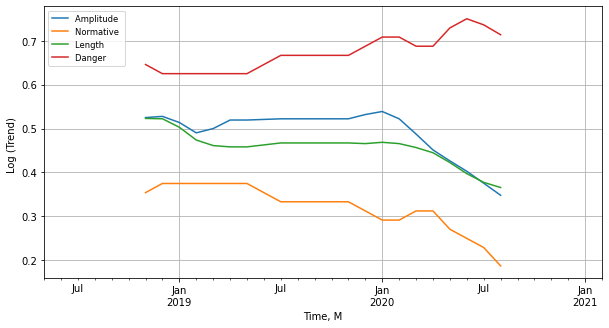

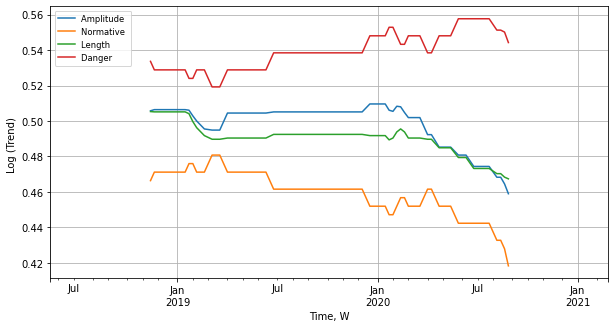

In [ ]:
discr=['Y', 'Q', 'M', 'W'] 
colraw=['Amplitude','Normative', 'Length', 'Danger']
for freq in discr:
  for col in colraw: 
      label=col
      decomposition=sm.tsa.seasonal_decompose(dfrm[col].resample(freq).mean().fillna(0.5) , model='additive') 
      decomposition.trend.plot(grid=True, label='%s ' % label, figsize=(10,5))
      plt.legend(loc='upper left', fontsize='small')
      plt.xlabel("Time, "+ freq)
      plt.ylabel('Log (Trend) ')
  plt.show()
      

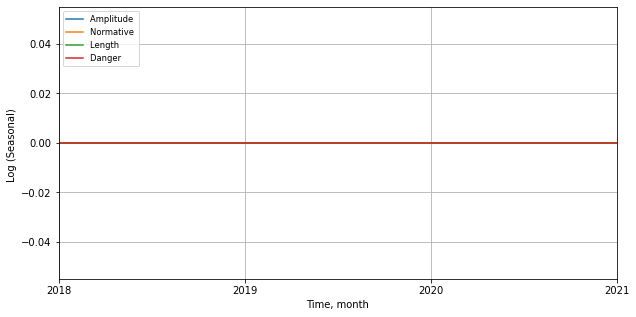

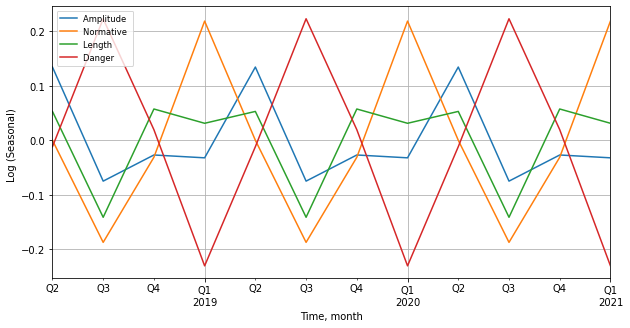

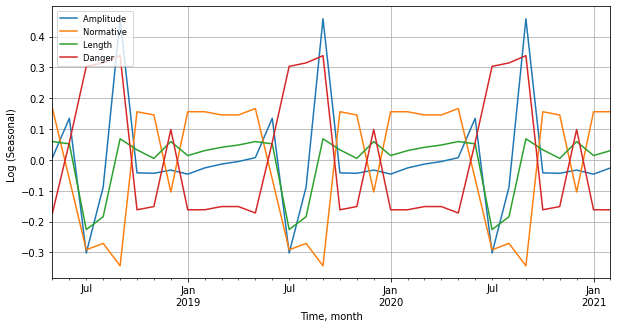

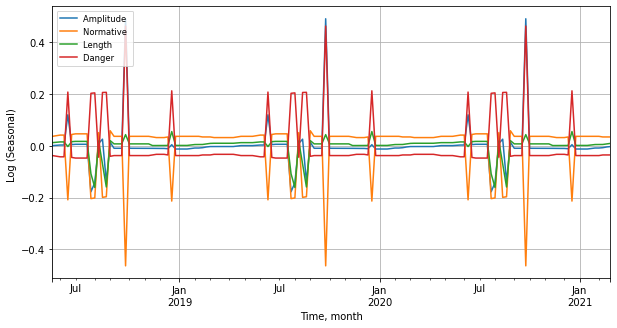

In [ ]:
discr=['Y', 'Q', 'M', 'W'] 
colraw=['Amplitude','Normative', 'Length', 'Danger']
model=['additive']
for freq in discr:
  for col in colraw: 
      label=col 
      decomposition=sm.tsa.seasonal_decompose(dfrm[col].resample(freq).mean().fillna(0.5) , model='additive') 
      decomposition.seasonal.plot(grid=True, label='%s ' % label, figsize=(10,5)) 
      plt.legend(loc='upper left', fontsize='small')
      plt.xlabel("Time, month")
      plt.ylabel('Log (Seasonal) ')
  plt.show()

# 3D matrix

In [29]:
miss=df.set_index(['Code', 'Intervals','Time']).drop(columns=['Month','Day','Km','M','Year', 'Normative'])
#miss = miss[~miss.index.duplicated()]
cols=['Amplitude', 'Length', 'Deviation','Square_A', 'Square_D']
miss

Amplitude  Danger  Length    Type   Track  \
Code Intervals Time                                                    
2065 0         2018-05-18         18       2      33  Others   19146   
               2018-05-18         13       2      14  Others   19801   
               2018-07-24         17       2      26  Others   19839   
               2018-08-13         19       2      23  Others   19595   
               2018-08-13         22       2      26  Others   19838   
...                              ...     ...     ...     ...     ...   
     1         2021-02-21         14       1      26  Others  633772   
               2021-02-21         14       1      23  Others  633837   
               2021-02-21         11       1      17  Others  638654   
               2021-02-21         13       2      19  Others  638677   
               2021-02-21         22      34      18  Others  639269   

                           Deviation  Square_A  Square_D              Bin  
Code Intervals Time                                                        
2065 0         2018-05-18         18       594       594  (18.369, 334.5]  
               2018-05-18         13       182       182  (18.369, 334.5]  
               2018-07-24         17       442       442  (18.369, 334.5]  
               2018-08-13         19       437       437  (18.369, 334.5]  
               2018-08-13         22       572       572  (18.369, 334.5]  
...                              ...       ...       ...              ...  
     1         2021-02-21         14       364       364   (334.5, 650.0]  
               2021-02-21         14       322       322   (334.5, 650.0]  
               2021-02-21         11       187       187   (334.5, 650.0]  
               2021-02-21         13       247       247   (334.5, 650.0]  
               2021-02-21         22       396       396   (334.5, 650.0]  

[1657 rows x 9 columns]

## Density functions

In [31]:
def KDE_function(dtfr, cols, HUE):
 sns.set(rc= {'figure.figsize' : (6, 4)})
 discr=['Y', 'Q']  
 significance_level = 0.05
 sns.set_style("whitegrid")
 fig, ax = plt.subplots()
 for col in cols:
  for freq in discr:
    ops=dtfr.reset_index().set_index('Time').resample(freq, origin='start').agg({col: 'mean', HUE:'first'}).fillna('ffill')
    grouped_data = ops.groupby(HUE)[col]
    for name, group in grouped_data:
            if not (group.max() == group.min()):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    stat, p = shapiro(group)
                
                if (p > significance_level) and (p < 1.0):
                    print(f"Danger degree: {name}, Shapiro-Wilk test statistic: {stat}, p-value: {p}, Normally distributed")
                    sns.kdeplot(data=ops, x=col,  multiple="stack") #, palette='Set2')
                    plt.xlabel([col, freq]) 
                    plt.ylabel('Pdf')
                    plt.grid(True)
                    plt.show()

Danger degree: 2, Shapiro-Wilk test statistic: 0.9930670261383057, p-value: 0.8407913446426392, Normally distributed


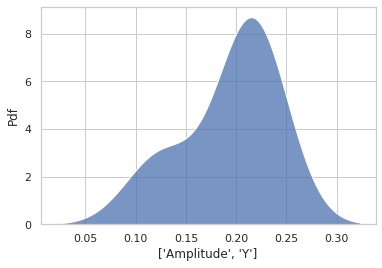

Danger degree: 2, Shapiro-Wilk test statistic: 0.95290207862854, p-value: 0.6797198057174683, Normally distributed


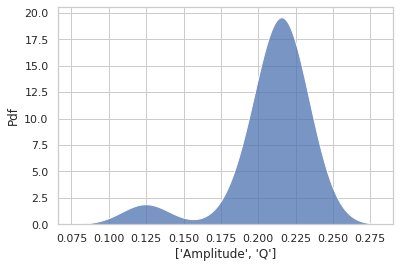

Danger degree: 2, Shapiro-Wilk test statistic: 0.8379931449890137, p-value: 0.20884528756141663, Normally distributed


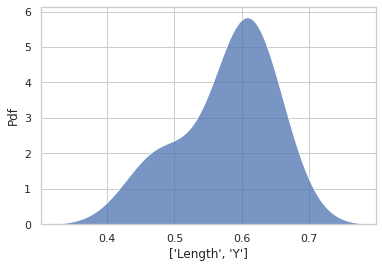

Danger degree: 2, Shapiro-Wilk test statistic: 0.9285990595817566, p-value: 0.3654992878437042, Normally distributed


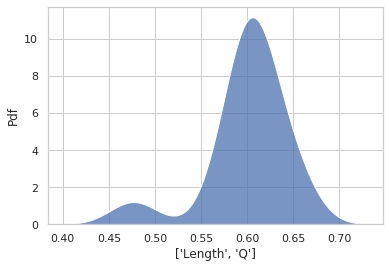

Danger degree: 2, Shapiro-Wilk test statistic: 0.9930670261383057, p-value: 0.8407913446426392, Normally distributed


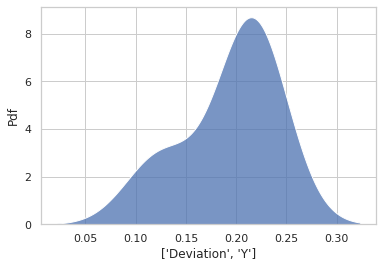

Danger degree: 2, Shapiro-Wilk test statistic: 0.95290207862854, p-value: 0.6797198057174683, Normally distributed


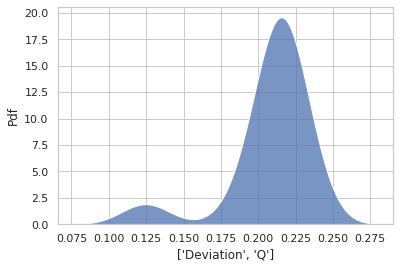

Danger degree: 2, Shapiro-Wilk test statistic: 0.9259979724884033, p-value: 0.4738228917121887, Normally distributed


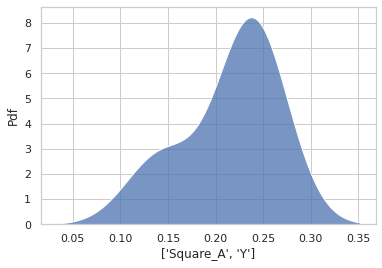

Danger degree: 2, Shapiro-Wilk test statistic: 0.9263429641723633, p-value: 0.34295547008514404, Normally distributed


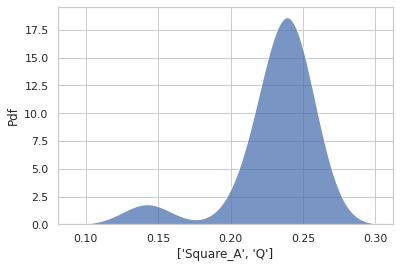

Danger degree: 2, Shapiro-Wilk test statistic: 0.9259979724884033, p-value: 0.4738228917121887, Normally distributed


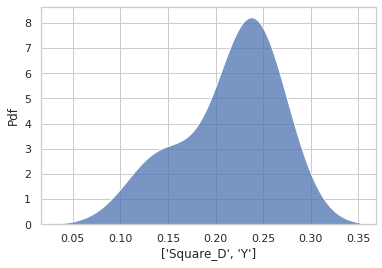

Danger degree: 2, Shapiro-Wilk test statistic: 0.9263429641723633, p-value: 0.34295547008514404, Normally distributed


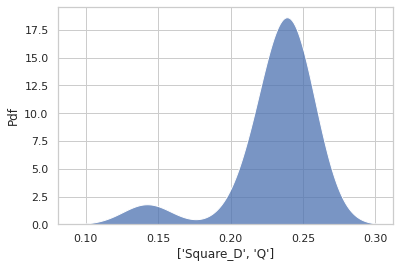

In [33]:
cols=['Amplitude', 'Length', 'Deviation','Square_A', 'Square_D']
scaler = MinMaxScaler(feature_range=(0, 1))
ms=miss.copy()
ms[cols] = scaler.fit_transform(ms[cols].to_numpy())
cls=cols+['Danger']
KDE_function(ms[cls], cls, 'Danger')

## Statistics

<Axes: xlabel='Month', ylabel='Count'>

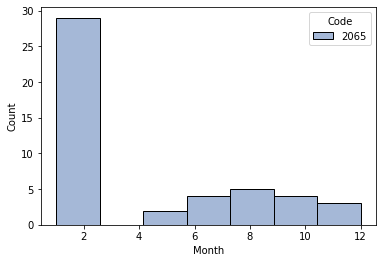

In [ ]:
 sns.histplot(data=df, x='Month', hue='Code', palette='deep')

<Axes: xlabel='Km', ylabel='Count'>

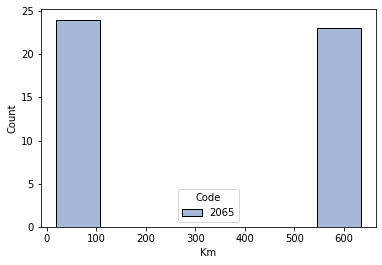

In [ ]:
sns.histplot(data=df, x='Km', hue='Code', palette='deep')

In [ ]:
from pandas.plotting import parallel_coordinates
fig = px.parallel_categories(raw[['Day', 'Month',"Year", "Code", 'Danger']], color='Danger' )
fig.show()

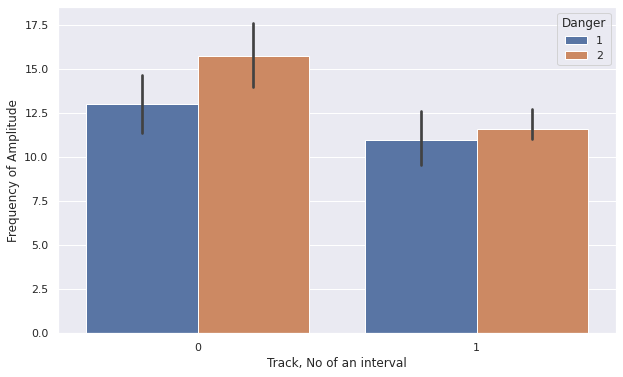

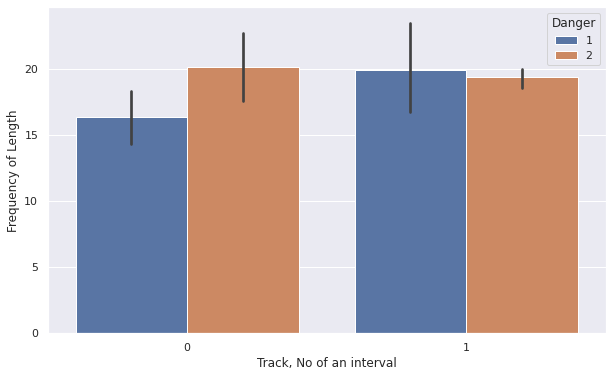

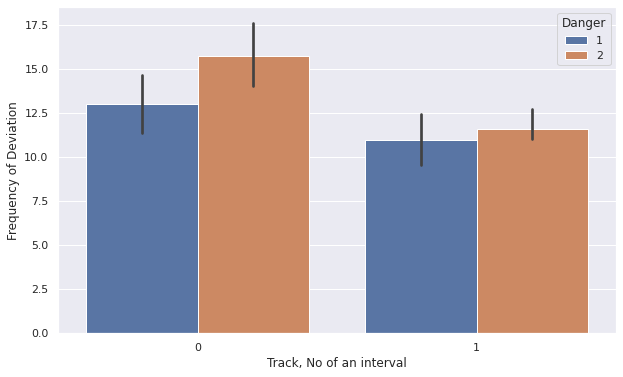

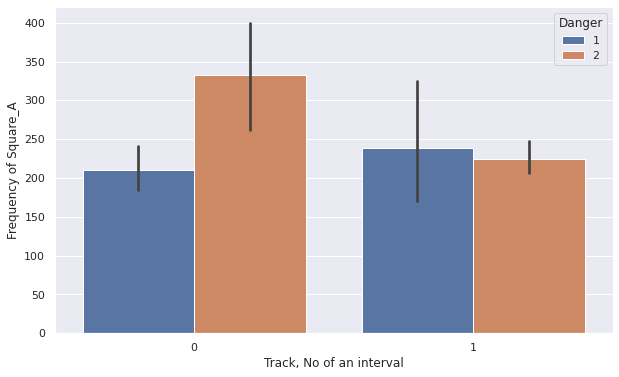

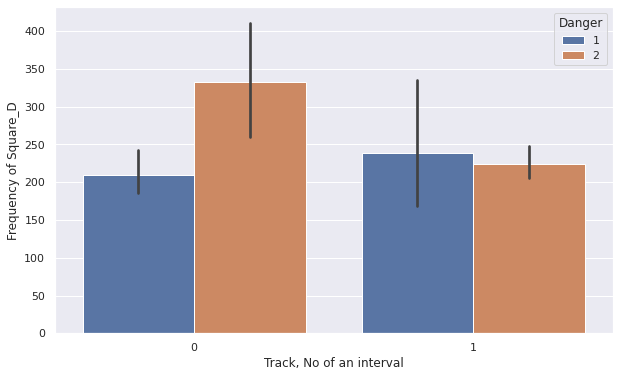

In [ ]:
sns.set( rc = {'figure.figsize' : ( 10, 6 ) })  
cols=['Amplitude', 'Length', 'Deviation','Square_A', 'Square_D']
for col in cols:
 ax=sns.barplot(x='Intervals', y=col, hue='Danger', data=df) 
 ax.set(xlabel='Track, No of an interval', ylabel='Frequency of '+col ) 
 plt.show()

# Forecast

In [12]:
dq=df.drop(columns=['Month','Day','Km','M','Year', 'Normative']).copy() 
cols=['Amplitude', 'Length', 'Deviation','Square_A', 'Square_D']
scaler = MinMaxScaler(feature_range=(0.1, 1))
ms=dq.copy()
ms[cols] = scaler.fit_transform(ms[cols].to_numpy())
print(ms.sample(2))

     Amplitude  Code  Danger    Length    Type       Time   Track  Deviation  \
510   0.255769  2065       2  0.756757  Others 2020-02-27  618490   0.255769   
240   0.221154  2065       2  0.221622  Others 2018-07-19  631934   0.221154   

     Square_A  Square_D  Intervals             Bin  
510  0.319832  0.319832          1  (334.5, 650.0]  
240  0.134286  0.134286          1  (334.5, 650.0]  


In [28]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

def forecast(df, column, intervals, code):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, n_changepoints=13)
    m.fit(df)
    
    # create future dataframe for test set
    future = m.make_future_dataframe(periods=365)
    future = future[future['ds'].isin(df['ds'])]
    
    # make predictions on test set
    forecast = m.predict(future)
    
    # calculate prediction errors
    mae = mean_absolute_error(df['y'], forecast['yhat'])
    mape = mean_absolute_percentage_error(df['y'], forecast['yhat'])
    mse = mean_squared_error(df['y'], forecast['yhat'])
    
    if mae < 0.15:
        forecast_group = forecast[['ds', 'yhat']].copy()
        forecast_group.loc[:, 'Column'] = column
        forecast_group.loc[:, 'Intervals'] = intervals
        forecast_group.loc[:, 'Code'] = code
        forecast_group.loc[:, 'y'] = df['y'].values
        forecast_group.loc[:, 'mae'] = mae
        forecast_group.loc[:, 'mape'] = mape
        forecast_group.loc[:, 'mse'] = mse
#        m.plot(forecast)
#        plt.title(f'{column} - {intervals} - {code}\nMAE: {mae:.3f}, MAPE: {mape:.3f}, MSE: {mse:.3f}')
#        plt.show()
        return forecast_group
    else:
        return None

param_grid = [] 
for bins in range(2, 9): 
  for yearly_seasonality in [True, False]: 
    for weekly_seasonality in [True, False]: 
      for daily_seasonality in [True, False]: 
        for n_changepoints in range(4): 
          params = {'bins': bins, 'yearly_seasonality': yearly_seasonality,
                    'weekly_seasonality': weekly_seasonality, 'daily_seasonality': daily_seasonality,
                    'n_changepoints': n_changepoints} 
          param_grid.append(params)

#initialize predictions dataframe
predictions = pd.DataFrame(columns=['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse'])

#iterate over parameter grid
for params in param_grid: 
  # apply binning to Track column 
  dp = ms.copy() 
  cols = ['Amplitude', 'Length', 'Deviation', 'Square_A', 'Square_D', 'Danger']
  dp.loc[:, 'Intervals'] = pd.cut(x=dp['Track'], bins=params['bins'], labels=False) 
  dp.loc[:, 'Bin'] = pd.cut(x=dp['Track'], bins=params['bins'])
  
  
  # group dataframe by Intervals and Code
  groups = dp.groupby(['Intervals', 'Code'])
  # for each group, forecast specified columns using Prophet and append results to predictions dataframe
  for name, group in groups:
    for col in cols:
      grouped = group.loc[:, ['Time', col]].rename(columns={'Time': 'ds', col: 'y'})
      grouped = grouped.set_index('ds').resample('D').mean().dropna().reset_index()
      try:
          forecast_group = forecast(grouped, col, name[0], name[1])
          if forecast_group is not None:
              forecast_group.loc[:, 'Intervals'] = name[0]
              forecast_group.loc[:, 'Code'] = name[1]
              forecast_group.loc[:, 'Column'] = col
              predictions = pd.concat([predictions, forecast_group[['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse']]])
        #      print(f"Forecasts for {col} - {name[0]} - {name[1]}:\n{forecast_group}")
      except Exception as e:
          print(f"Error in forecast for {col} - {name[0]} - {name[1]}: {str(e)}")
          pass

sorted_predictions = predictions.sort_values(by=['mae', 'mape', 'mse'], ascending=[True, True, True]) 
if not sorted_predictions.empty: 
  best_params = {'bins': sorted_predictions.iloc[0]['Intervals'], 'yearly_seasonality': params['yearly_seasonality'], 
                 'weekly_seasonality': params['weekly_seasonality'], 'daily_seasonality': params['daily_seasonality'], 
                 'n_changepoints': params['n_changepoints']} 
  print(f"Best parameters: {best_params}") 
else: 
  print("No predictions found.")


Best parameters: {'bins': 1, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'n_changepoints': 3}


In [ ]:
def find_best_parameters(df, column, intervals, code):
    # initialize variables for best parameters and best error values
    best_params = {}
    best_mae = np.inf
    best_mape = np.inf
    best_mse = np.inf
    
    # add different resampling frequencies
    resampling_options = ['M']
    
    # try different parameter values and resampling frequencies
    for yearly in [False, True]:
        for weekly in [False, True]:
            for daily in [False, True]:
                for changepoints in [0, 1, 2, 3]:
                    for resampling in resampling_options:
                        # resample the column data
                        df_resampled_col = df[column].resample(resampling).mean().fillna(method='bfill')
                        print(df_resampled_col)
                        # create a new DataFrame with the resampled column and the original dates
                        df_resampled = pd.DataFrame({
                            'ds': df_resampled_col.index,
                            'y': df_resampled_col.values
                        })
                        
                        # train the model with the current parameter values and resampled data
                        m = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, 
                                    daily_seasonality=daily, n_changepoints=changepoints)
                        m.fit(df_resampled)

                        # make predictions
                        future = m.make_future_dataframe(periods=365, freq=resampling)
                        forecast = m.predict(future)

                        # evaluate the predictions on the resampled data
                        df_resampled = df_resampled.merge(forecast[['ds', 'yhat']], how='left', on='ds')
                        df_resampled = df_resampled.dropna()
                        mae = mean_absolute_error(df_resampled['y'], df_resampled['yhat'])
                        mape = mean_absolute_percentage_error(df_resampled['y'], df_resampled['yhat'])
                        mse = mean_squared_error(df_resampled['y'], df_resampled['yhat'])

                        # check if the current parameter values are the best so far
                        if mae < best_mae and mape < best_mape and mse < best_mse:
                            best_params = {'yearly_seasonality': yearly, 'weekly_seasonality': weekly, 
                                           'daily_seasonality': daily, 'n_changepoints': changepoints, 'freq': resampling}
                            best_mae = mae
                            best_mape = mape
                            best_mse = mse
    
    # return the best parameters and error values
    return best_params, best_mae, best_mape, best_mse

# define function to forecast columns using Prophet, and return a dataframe with predictions and the Prophet model
def forecast(df, column, intervals, code):
    # find the best parameter values
    best_params, mae, mape, mse = find_best_parameters(df, column, intervals, code)
    
    # train the model with the best parameter values and resampled data
    m = Prophet(**best_params)
    m.fit(df.resample(best_params['freq']).mean().fillna(method='bfill'))
    
    # make predictions
    future = m.make_future_dataframe(periods=365, freq=best_params['freq'])
    forecast = m.predict(future)
    
    # plot the predictions if the error is low enough
    if mae < 0.1:
        m.plot(forecast)
        plt.title(f'{column} - {intervals} - {code}\nMAE: {mae:.3f}, MAPE: {mape:.3f}, MSE: {mse:.3f}')
    
    # return the predictions dataframe and error values
    return forecast[['ds', 'yhat']], mae, mape, mse

dp = ms.copy().reset_index()
cols = ['Amplitude', 'Length', 'Deviation', 'Square_A', 'Square_D', 'Danger']

# empty dataframe to store predictions
predictions = pd.DataFrame(columns=['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse'])

# group dataframe by Intervals and Code
groups = dp.groupby(['Intervals', 'Code'])

# for each group, forecast specified columns using Prophet and append results to predictions dataframe
for name, group in groups:
    for col in cols:
        grouped = group.loc[:, ['Time', col]].rename(columns={'Time': 'ds', col: 'y'})
        try:
            print(grouped)
            forecast_group, mae, mape, mse = forecast(grouped, col, name[0], name[1])
            forecast_group['Column'] = col
            forecast_group['Intervals'] = name[0]
            forecast_group['Code'] = name[1]
            forecast_group['y'] = grouped['y']
            forecast_group['mae'] = mae
            forecast_group['mape'] = mape
            forecast_group['mse'] = mse
            predictions = pd.concat([predictions, forecast_group[['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse']]])
        except:
            pass

# sort predictions dataframe by mae, mape, and mse in ascending order
sorted_predictions = predictions.sort_values(by=['mae', 'mape', 'mse'], ascending=[True, True, True])
sorted_predictions

             ds         y
0    2018-05-18  0.290385
1    2018-05-18  0.203846
2    2018-07-24  0.273077
3    2018-08-13  0.307692
4    2018-08-13  0.359615
...         ...       ...
1621 2021-02-15  0.169231
1622 2021-02-15  0.255769
1623 2021-02-15  0.151923
1624 2021-02-15  0.273077
1625 2021-02-15  0.290385

[334 rows x 2 columns]
             ds         y
0    2018-05-18  0.829730
1    2018-05-18  0.367568
2    2018-07-24  0.659459
3    2018-08-13  0.586486
4    2018-08-13  0.659459
...         ...       ...
1621 2021-02-15  0.391892
1622 2021-02-15  0.586486
1623 2021-02-15  0.489189
1624 2021-02-15  1.000000
1625 2021-02-15  0.489189

[334 rows x 2 columns]
             ds         y
0    2018-05-18  0.290385
1    2018-05-18  0.203846
2    2018-07-24  0.273077
3    2018-08-13  0.307692
4    2018-08-13  0.359615
...         ...       ...
1621 2021-02-15  0.169231
1622 2021-02-15  0.255769
1623 2021-02-15  0.151923
1624 2021-02-15  0.273077
1625 2021-02-15  0.290385

[334 rows x 2 c

,Intervals,Code,Column,ds,y,yhat,mae,mape,mse


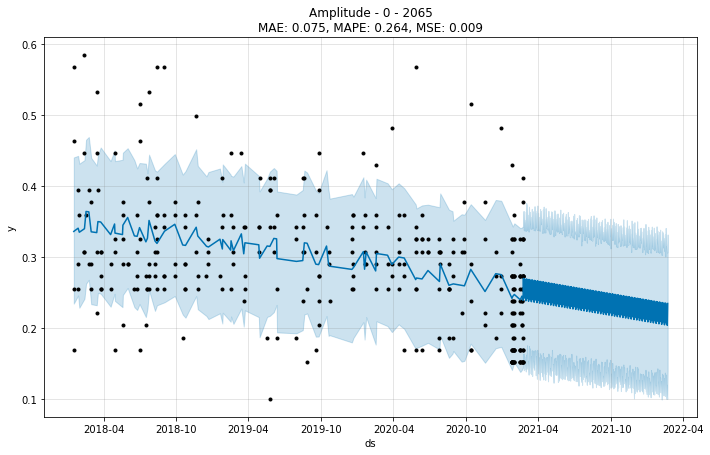

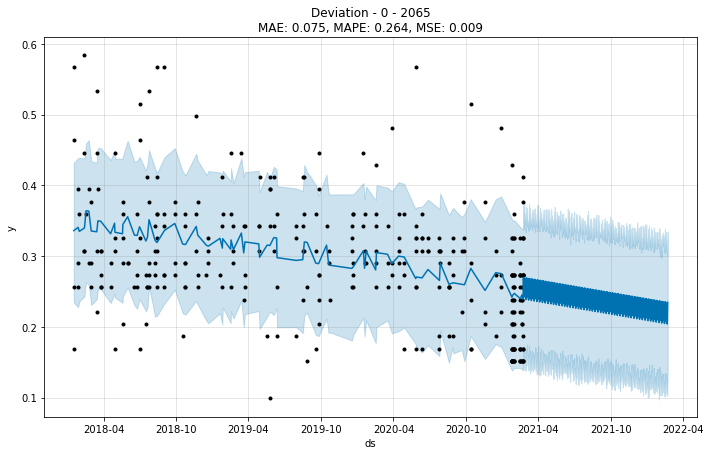

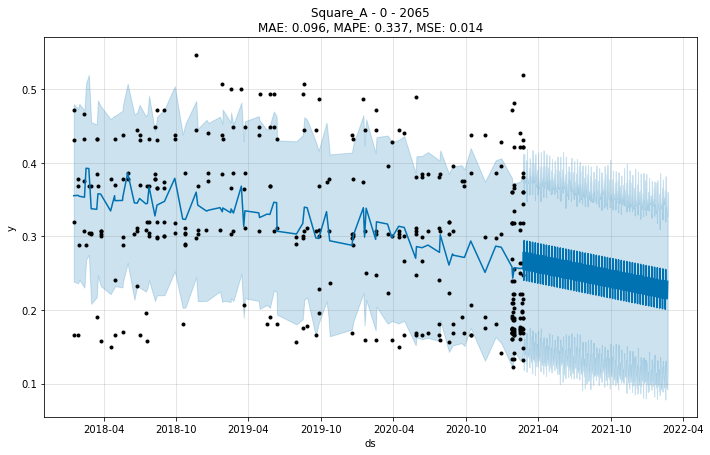

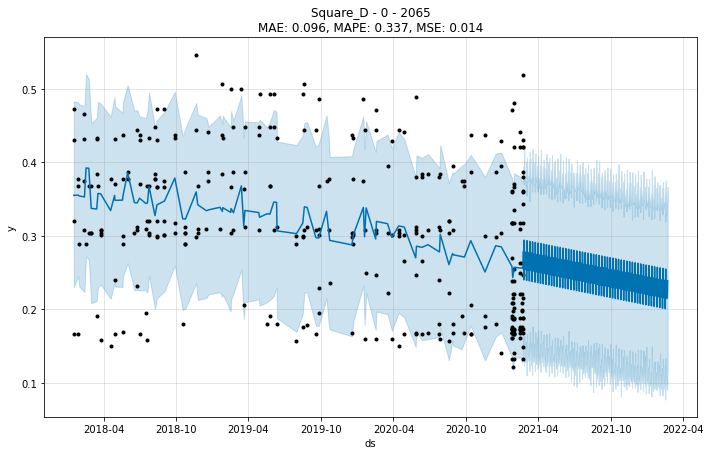

In [ ]:
# define a function to find the best parameter values
def find_best_parameters(df, column, intervals, code):
    # initialize variables for best parameters and best error values
    best_params = {}
    best_mae = np.inf
    best_mape = np.inf
    best_mse = np.inf
    
    # try different parameter values
    for yearly in [False, True]:
        for weekly in [False, True]:
            for daily in [False, True]:
                for changepoints in [10, 15, 20]:

                    # train the model with the current parameter values
                    m = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, 
                                daily_seasonality=daily, n_changepoints=changepoints)
                    m.fit(df)

                    # make predictions
                    future = m.make_future_dataframe(periods=365) #for days
                  #  future = m.make_future_dataframe(periods=52, freq='W')
                    forecast = m.predict(future)

                    # evaluate the predictions
                    mae = mean_absolute_error(df['y'], forecast['yhat'][:len(df['y'])])
                    mape = mean_absolute_percentage_error(df['y'], forecast['yhat'][:len(df['y'])])
                    mse = mean_squared_error(df['y'], forecast['yhat'][:len(df['y'])])

                    # check if the current parameter values are the best so far
                    if mae < best_mae and mape < best_mape and mse < best_mse:
                        best_params = {'yearly_seasonality': yearly, 'weekly_seasonality': weekly, 
                                       'daily_seasonality': daily, 'n_changepoints': changepoints}
                        best_mae = mae
                        best_mape = mape
                        best_mse = mse

    # return the best parameters and error values
    return best_params, best_mae, best_mape, best_mse

# define function to forecast columns using Prophet, and return a dataframe with predictions and the Prophet model
def forecast(df, column, intervals, code):
    # find the best parameter values
    best_params, mae, mape, mse = find_best_parameters(df, column, intervals, code)
    
    # train the model with the best parameter values
    m = Prophet(**best_params)
    m.fit(df)
    
    # make predictions
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    
    # plot the predictions if the error is low enough
    if mae < 0.1:
        m.plot(forecast)
        plt.title(f'{column} - {intervals} - {code}\nMAE: {mae:.3f}, MAPE: {mape:.3f}, MSE: {mse:.3f}')
    
    # return the predictions dataframe and error values
    return forecast[['ds', 'yhat']], mae, mape, mse

dp = ms.copy().reset_index()
cols = ['Amplitude', 'Length', 'Deviation', 'Square_A', 'Square_D', 'Danger']

# empty dataframe to store predictions
predictions = pd.DataFrame(columns=['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse'])

# group dataframe by Intervals and Code
groups = dp.groupby(['Intervals', 'Code'])

# for each group, forecast specified columns using Prophet and append results to predictions dataframe
for name, group in groups:
    for col in cols:
        grouped = group.loc[:, ['Time', col]].rename(columns={'Time': 'ds', col: 'y'})
        try:
            forecast_group, mae, mape, mse = forecast(grouped, col, name[0], name[1])
            forecast_group['Column'] = col
            forecast_group['Intervals'] = name[0]
            forecast_group['Code'] = name[1]
            forecast_group['y'] = grouped['y']
            forecast_group['mae'] = mae
            forecast_group['mape'] = mape
            forecast_group['mse'] = mse
            predictions = pd.concat([predictions, forecast_group[['Intervals', 'Code', 'Column', 'ds', 'y', 'yhat', 'mae', 'mape', 'mse']]])
        except:
            pass

# sort predictions dataframe by mae, mape, and mse in ascending order
sorted_predictions = predictions.sort_values(by=['mae', 'mape', 'mse'], ascending=[True, True, True])


In [37]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
discr=['M'] #,'2M', '3W','6W', '7W','Q', '2Q', '3Q','Y']
days_dict = {'D':1, '2W': 14, 'M': 30, '2M': 60, '3W': 21, '6W': 42, '7W': 49, 'Q':90, '2Q': 180, '3Q': 270, 'Y': 365}
cols=['Amplitude', 'Length', 'Deviation','Square_A', 'Square_D','Danger']
new_values = []
for freq in discr:
    for col in cols:
        for i in range(2): 
            new_value = {'FREQ': freq, 'Parameter': col, 'Change_points': i}
            new_values.append(new_value)

# create a new dataframe from the list of dictionaries
new_df = pd.DataFrame(new_values)

for freq in discr:
# create a list of new values
    
    for col in cols:
        dp=ms.reset_index().set_index('Time').resample('D').agg({col: 'mean', 'Code':'last', 'Intervals':'last'}).fillna(method="ffill").reset_index() 
        dp.rename(columns={col:'y', 'Time':'ds'}, inplace=True)  
        ops=dp.groupby(['Intervals','Code']) [['ds','y']]

        forecast=[]
        forecast = pd.DataFrame(columns=['ds', 'y', 'Group'])
        pm_results_list = []
        for name, group in ops: 
            group_name = str(name[0]) + '_' + str(name[1])
            group_forecast = pd.DataFrame({'ds': group['ds'], 'y': group['y'], 'Group': group_name})
            forecast = pd.concat([forecast, group_forecast], ignore_index=True)
            
            predictions=1
            days = [days_dict[freq] for freq in discr]
            period_days = days_dict[freq]
            predictions_days=days_dict[freq] * predictions        
        
            initial_days = len(group) #days_dict[freq] * 
            print(f'{len(group)} length of group') #, f'{len(train)} length of train' , f'{len(test)} length of test')
           
            if (len(group)>3): 
                for i in range(round(len(group)/2)):
                    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, n_changepoints=i) 
                  #  m.add_seasonality(name='monthly', period=period_days, fourier_order=5) 
                  #  m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5, prior_scale=0.02)
                  #  m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
                    m.fit(group) 
                    future = m.make_future_dataframe(periods=predictions_days,freq='D')
               #     future = m.predict(test)
                    print(f'{predictions_days} predictions_days', f'{freq} freq')
#                    future = m.make_future_dataframe(periods=120, freq=freq)
                    forecast = m.predict(future)[-30:]
                    try:
                        print(f'{initial_days} initial days', f'{period_days} period', f'{predictions_days} horizon')
                        cv_results = cross_validation(m, period=predictions_days, horizon=100) #initial=f'{initial_days} days', period=f'{period_days} days',f'{predictions_days} days'
                        pm_results = performance_metrics(cv_results)
                        pm_results[f'FREQ'] = freq
                        pm_results[f'Parameter'] = col
                        pm_results[f'Change_points'] = i
                        pm_results[f'Group'] = group_name # add a new column with the group name to the pm_results dataframe
                        pm_results_list.append(pm_results)
                        if (pm_results['mae'].mean()<=0.1):
                           plt.rc('figure', max_open_warning = 0)
                           fig=m.plot(forecast,  ylabel =str(col)+" for Intervals, Code: "+str(name)) 
                           m.plot_components(forecast)
                           plt.xlabel('Time, '+str(freq)+ ' for '+str(col))
                           plt.show()   
                           plt.close()
                           # concatenate the new dataframe with the existing pm_results dataframe
                           new_df = pd.concat([pm_results, new_df], ignore_index=True)
                    except ValueError:
                        print("Error: Less data than horizon after initial window. Make horizon or initial shorter.")
                    except Exception as e:
                        print("Error:", e)
                    else:
                        continue

16:08:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send


666 length of group
30 predictions_days M freq
666 initial days 30 period 30 horizon


INFO:prophet:Making 392 forecasts with cutoffs between 2019-01-15 23:59:59.999999900 and 2021-02-22 23:59:59.999999900


  0%|          | 0/392 [00:00<?, ?it/s]

16:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
16:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
16:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
16:08:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
16:08:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
16:08:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Com

KeyboardInterrupt: ignored

In [36]:
metrics_df = new_df.groupby(['FREQ', 'Parameter', 'Change_points','Group']).mean().reset_index().dropna()
metrics_df

,FREQ,Parameter,Change_points,Group,mse,rmse,mae,mape,mdape,smape,coverage
0,M,Amplitude,0,0.0_2065.0,0.002968,0.054477,0.039429,0.218575,0.101237,0.181768,0.647959
1,M,Amplitude,1,0.0_2065.0,0.002851,0.053397,0.036899,0.204117,0.081861,0.173198,0.678571
2,M,Amplitude,2,0.0_2065.0,0.002859,0.053468,0.037007,0.204489,0.098083,0.174201,0.686224
3,M,Amplitude,3,0.0_2065.0,0.002836,0.053257,0.036913,0.203777,0.096994,0.173996,0.681122
4,M,Amplitude,4,0.0_2065.0,0.002815,0.053056,0.036730,0.202577,0.093996,0.173384,0.686224
...,...,...,...,...,...,...,...,...,...,...,...
70,M,Amplitude,70,0.0_2065.0,0.002790,0.052816,0.036380,0.200996,0.097408,0.171427,0.688776
71,M,Amplitude,71,0.0_2065.0,0.002784,0.052760,0.036349,0.200808,0.098397,0.171270,0.691327
72,M,Amplitude,72,0.0_2065.0,0.002783,0.052757,0.036321,0.200669,0.097593,0.171123,0.693878
73,M,Amplitude,73,0.0_2065.0,0.002785,0.052776,0.036336,0.200779,0.096454,0.171235,0.688776
